#EE6350 Artificial Intelligence

## Handwritten Text Recognition

### The purpose of this project is to give a brief idea and a basic approach for offline handwritten text recognition by using segmentation and classification.

## Approach

* **Step1** :  Build a digit(0-9) + A-Z characters classifier using a CNN architecture.
* **Step2** :  Apply character segmentation for the handwritten word image.
* **Step3** :  Classify each segmented letter and then get the final word in the image.


### Handwritten Text Recognition - Data Preparation
   
1. Importing Necessary Libraries
   
2. Setting Up Dataset Download Parameters
   
3. Preparing Kaggle Directories
   
4. Cleaning and Creating Directories
   
5. Creating Symbolic Links
   
6. Downloading and Extracting Datasets
   
7. Completion Message

In [5]:
import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'handwritten-characters:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F53376%2F101598%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240620%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240620T193810Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D102ee0945e01ca00bd292dad7c5d14d01dc1a599bcb1ed51bc0046a7f393bc27387bada1edd37ebd335bf3bb7b8cfc81e570feb495eea88438e362510e1a2705af573c8dbea66b32694b610ff851119f614a69df42628a94877b120248b3f470fb1465574118d47d1963221307e8af1bb0cd3a580019a307929ee664ef33ec6b9e7de738239e6688a195771a64ca041aec7a5855be7089ba8e2acc0ba6749962a516f2905e587e0f8213dd8b33e2351d36d06caa2dd327acefa21c73c558cd39ea4bc3dbab499c1ce002ce92a62f042ef9d4acee8d166467afab9cb886c064ef6bcf6bf643c2ffce26fae4ed66a6734f3849c49311dab3637c937092beb5e457,handwriting-recognition:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F818027%2F1400106%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240620%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240620T193810Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D5b5abd12819a47f4f205ded6d2a5c89bf7f4ee48709f8fdd7a58bae65ea0935a347c51f49ffdcabe7964ad47dfa88d967b950797149cabb51bd60e0990241960849ebbe9e5021e1c6155fb238e041df5dcc87da9659b71009eac6b03a102efb5bf6ee35ab38dae8f2db1f03905c90cfccfe5a5e8d77bf60c34cdb5bb5a7f0df66affb907375a72a1ce34c2ed6f8e7da29ddb477b7abf784e1d43801d4af32c4cd1a483ea137327a8b0fda0a9fe20fe04683524a8cd216289322c1b3bf8c7aa04572531e1e05f6a2556e7d36303846aeea1a2d54cb6afce9e6baed126015b3a9b956a7c52c1b9da99e91033bc769f7c8e41362de1802559565388a8cd26a8698c'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 1740501298 bytes downloaded
Downloaded and uncompressed: handwritten-characters
[==================================================] 1353071625 bytes downloaded
Downloaded and uncompressed: handwriting-recognition
Data source import complete.


In [6]:
!pip install imutils

## **Importing Libraries for Data Handling and Model Building**

In this section, we import a comprehensive set of libraries necessary for handling data and building our machine learning model for handwritten text recognition. These libraries provide tools for data manipulation, preprocessing, visualization, and deep learning model construction.

In [7]:
import numpy as np
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator
import os
import random
import cv2
import imutils
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelBinarizer
# Instead of keras.utils import np_utils use the below import
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras import optimizers
from sklearn.preprocessing import LabelBinarizer
from keras import backend as K
from keras.layers import Dense, Activation, Flatten, Dense,MaxPooling2D, Dropout
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization

## **Preparing the Training Data**

In this section, we set up the directory path for our training dataset and preprocess the images to make them ready for model training. This involves reading images, resizing them to a uniform size, and filtering out specific non-character images. The preprocessed images are then stored in a list along with their respective labels.

In [8]:
dir = "../input/handwritten-characters/Train/"
train_data = []
img_size = 32
non_chars = ["#","$","&","@"]
for i in os.listdir(dir):
    if i in non_chars:
        continue
    count = 0
    sub_directory = os.path.join(dir,i)
    for j in os.listdir(sub_directory):
        count+=1
        if count > 4000:
            break
        img = cv2.imread(os.path.join(sub_directory,j),0)
        img = cv2.resize(img,(img_size,img_size))
        train_data.append([img,i])

In [9]:
len(train_data)

140000

## **Preparing the Validation Data**

In this section, we set up the directory path for our validation dataset and preprocess the images in a similar manner to the training dataset. This process includes reading and resizing the images, filtering out specific non-character images, and storing the preprocessed images along with their corresponding labels. Validation data helps in evaluating the model's performance on unseen data during the training phase.

In [10]:
val_dir = "../input/handwritten-characters/Validation/"
val_data = []
img_size = 32
for i in os.listdir(val_dir):
    if i in non_chars:
        continue
    count = 0
    sub_directory = os.path.join(val_dir,i)
    for j in os.listdir(sub_directory):
        count+=1
        if count > 1000:
            break
        img = cv2.imread(os.path.join(sub_directory,j),0)
        img = cv2.resize(img,(img_size,img_size))
        val_data.append([img,i])

In [11]:
len(val_data)

15209

In [12]:
random.shuffle(train_data)
random.shuffle(val_data)

 ## **Separating Features and Labels for Training Data**


This section focuses on splitting the preprocessed training data into two distinct lists: one for the features (images) and another for the labels (characters). This separation is essential for training the model, as it requires the input features to learn patterns and the corresponding labels to understand the classification targets.

In [13]:
train_X = []
train_Y = []
for features,label in train_data:
    train_X.append(features)
    train_Y.append(label)

## **Separating Features and Labels for Validation Data**

In this section, the validation data is split into two separate lists: one for the features (images) and one for the labels (characters). This separation is crucial for the subsequent evaluation of the model's performance on unseen data during the training phase.

In [14]:
val_X = []
val_Y = []
for features,label in val_data:
    val_X.append(features)
    val_Y.append(label)

## **Encoding Labels for Training and Validation Data**

In this section, the labels for both the training and validation datasets are encoded using LabelBinarizer from scikit-learn. This transformation converts categorical labels (characters) into binary vectors, which are essential for training and evaluating classification models.

In [15]:
LB = LabelBinarizer()
train_Y = LB.fit_transform(train_Y)
val_Y = LB.fit_transform(val_Y)

## **Preparing Training Data for Model Input**

In this section, the training data (train_X and train_Y) is prepared for input into the deep learning model. This involves scaling the pixel values of images and reshaping them to conform to the expected input shape of the model.

In [16]:
train_X = np.array(train_X)/255.0
train_X = train_X.reshape(-1,32,32,1)
train_Y = np.array(train_Y)

## **Preparing Validation Data for Model Evaluation**

In this section, the validation data (val_X and val_Y) is prepared for evaluation with the trained deep learning model. Similar to the training data preparation, this involves scaling the pixel values of images and reshaping them to match the expected input shape of the model.

In [17]:
val_X = np.array(val_X)/255.0
val_X = val_X.reshape(-1,32,32,1)
val_Y = np.array(val_Y)

In [18]:
print(train_X.shape,val_X.shape)

(140000, 32, 32, 1) (15209, 32, 32, 1)


In [19]:
print(train_Y.shape,val_Y.shape)

(140000, 35) (15209, 35)


## **Building a Convolutional Neural Network (CNN) for Handwritten Character Recognition**

This section outlines the construction of a Convolutional Neural Network (CNN) designed to recognize handwritten characters from images. CNNs are particularly effective for image classification tasks due to their ability to automatically learn hierarchical representations of visual data.

In [20]:
model = Sequential()

model.add(Conv2D(32, (3, 3), padding = "same", activation='relu', input_shape=(32,32,1)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(35, activation='softmax'))

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 16, 16, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 7, 7, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 5, 5, 128)         73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 2, 2, 128)         0

## **Compiling and Training the CNN Model for Handwritten Character Recognition**


This section covers compiling the CNN model with specified loss function, optimizer, and metrics, followed by training the model using training and validation datasets.

In [22]:
model.compile(loss='categorical_crossentropy', optimizer="adam",metrics=['accuracy'])

In [23]:
history = model.fit(train_X,train_Y, epochs=5, batch_size=32, validation_data = (val_X, val_Y),  verbose=1)

Epoch 1/5
4375/4375 [==============================] - 32s 6ms/step - loss: 0.6101 - accuracy: 0.8055 - val_loss: 0.3354 - val_accuracy: 0.8959
Epoch 2/5
4375/4375 [==============================] - 24s 5ms/step - loss: 0.3457 - accuracy: 0.8843 - val_loss: 0.2766 - val_accuracy: 0.9084
Epoch 3/5
4375/4375 [==============================] - 25s 6ms/step - loss: 0.2982 - accuracy: 0.8989 - val_loss: 0.2623 - val_accuracy: 0.9037
Epoch 4/5
4375/4375 [==============================] - 25s 6ms/step - loss: 0.2749 - accuracy: 0.9062 - val_loss: 0.2944 - val_accuracy: 0.8955
Epoch 5/5
4375/4375 [==============================] - 25s 6ms/step - loss: 0.2566 - accuracy: 0.9114 - val_loss: 0.2540 - val_accuracy: 0.9020


## **Visualizing Training Metrics: Accuracy and Loss**

After training the CNN model, it's essential to visualize how the training and validation metrics (accuracy and loss) evolve over epochs. This helps in understanding the model's performance and identifying any potential issues such as overfitting.

**Training Accuracy vs Validation Accuracy**

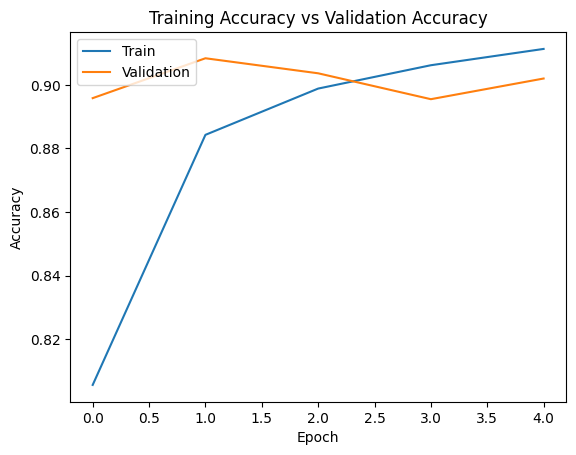

In [24]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training Accuracy vs Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

**Training Loss vs Validation Loss**

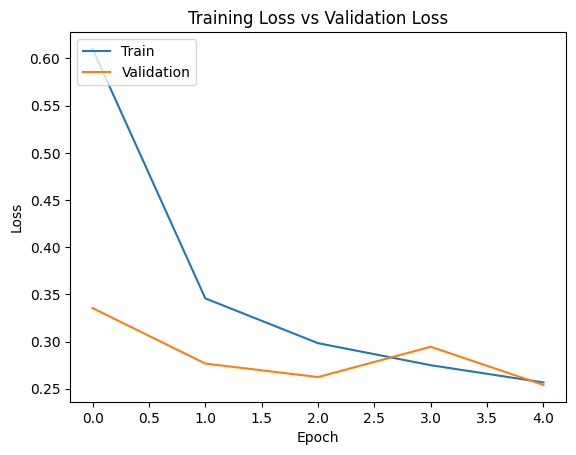

In [25]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training Loss vs Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

## Recognition and Post-Processing
1. The sort contours function is used to get the correct order of individual characters for correct output extraction. In this case for extracting a single word, a left to right sorting of individual characters is needed.
2. The get letters function fetches the list of letters and get word function gets the individual word.

In [26]:
# Define functions
def sort_contours(cnts, method="left-to-right"):
    reverse = False
    i = 0
    if method == "right-to-left" or method == "bottom-to-top":
        reverse = True
    if method == "top-to-bottom" or method == "bottom-to-top":
        i = 1
    boundingBoxes = [cv2.boundingRect(c) for c in cnts]
    (cnts, boundingBoxes) = zip(*sorted(zip(cnts, boundingBoxes),
                                        key=lambda b: b[1][i], reverse=reverse))
    return (cnts, boundingBoxes)

In [27]:
def get_letters(img_path, threshold_level=127, dilate_iter=2):
    letters = []
    image = cv2.imread(img_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    ret, thresh1 = cv2.threshold(gray, threshold_level, 255, cv2.THRESH_BINARY_INV)
    dilated = cv2.dilate(thresh1, None, iterations=dilate_iter)
    cnts = cv2.findContours(dilated.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    cnts = sort_contours(cnts, method="left-to-right")[0]

    for c in cnts:
        if cv2.contourArea(c) > 10:
            (x, y, w, h) = cv2.boundingRect(c)
            cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
            roi = gray[y:y + h, x:x + w]
            thresh = cv2.threshold(roi, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
            thresh = cv2.resize(thresh, (32, 32), interpolation=cv2.INTER_CUBIC)
            thresh = thresh.astype("float32") / 255.0
            thresh = np.expand_dims(thresh, axis=-1)
            thresh = thresh.reshape(1, 32, 32, 1)
            ypred = model.predict(thresh)
            ypred = LB.inverse_transform(ypred)
            [x] = ypred
            letters.append(x)

    return letters, image

In [28]:
def get_word(letters):
    return "".join(letters)

1/1 [==============================] - 0s 20ms/step
BZWE5


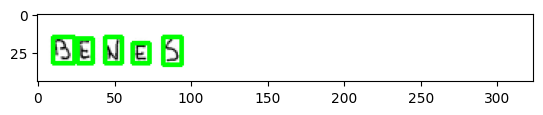

In [29]:
letter,image = get_letters("../input/handwriting-recognition/train_v2/train/TRAIN_00003.jpg")
word = get_word(letter)
print(word)
plt.imshow(image)

1/1 [==============================] - 0s 20ms/step
LIL0U


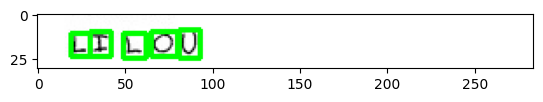

In [30]:
letter,image = get_letters("../input/handwriting-recognition/train_v2/train/TRAIN_00023.jpg")
word = get_word(letter)
print(word)
plt.imshow(image)

1/1 [==============================] - 0s 22ms/step
JAFFFUX


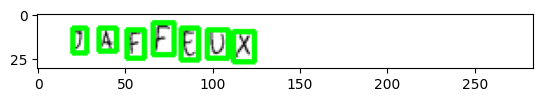

In [31]:
letter,image = get_letters("../input/handwriting-recognition/train_v2/train/TRAIN_00030.jpg")
word = get_word(letter)
print(word)
plt.imshow(image)

1/1 [==============================] - 0s 27ms/step
RUPP


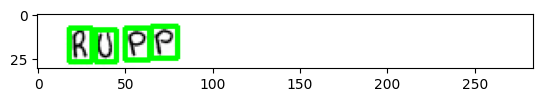

In [32]:
letter,image = get_letters("../input/handwriting-recognition/validation_v2/validation/VALIDATION_0005.jpg")
word = get_word(letter)
print(word)
plt.imshow(image)

##**Setting Up a Flask App for Handwritten Text Recognition with Tesseract**

This Flask application serves as an API endpoint to perform handwritten text recognition using Tesseract OCR. It allows users to upload an image file, processes it using Tesseract, and returns the extracted text.

In [ ]:
# Install pytesseract and Tesseract-OCR
!pip install flask flask_cors werkzeug Pillow pytesseract pyngrok
!apt-get update
!apt-get install -y tesseract-ocr
!apt-get install -y libtesseract-dev


# Import necessary libraries
from flask import Flask, request, jsonify
from flask_cors import CORS
from werkzeug.utils import secure_filename
import os
from PIL import Image
import pytesseract

app = Flask(__name__)
CORS(app)

@app.route('/predict', methods=['POST'])
def predict():
    if 'file' not in request.files:
        return jsonify({"error": "No file part"}), 400

    file = request.files['file']

    if file.filename == '':
        return jsonify({"error": "No selected file"}), 400

    if file:
        try:
            filename = secure_filename(file.filename)
            file_path = os.path.join("/tmp", filename)
            file.save(file_path)

            image = Image.open(file_path)
            text = pytesseract.image_to_string(image)
            os.remove(file_path)  # Clean up the file after processing

            return jsonify({"result": text})
        except Exception as e:
            print(f"Error processing image: {str(e)}")
            return jsonify({"error": f"Failed to process the image: {str(e)}"}), 500

    return jsonify({"error": "Unexpected error"}), 500

if __name__ == "__main__":
    from pyngrok import ngrok
    ngrok.set_auth_token("2iBJ3n0BF1nSnH0rw0lIwUuMvF2_7LhBUBKck2kztbwA7m4iR")
    public_url = ngrok.connect(5000)
    print(f"Your public URL is: {public_url}")
    app.run(host='0.0.0.0', port=5000)


Hit:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:3 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:4 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:6 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:7 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2.1build1).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.
Reading pac

INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on all addresses (0.0.0.0)
 * Running on http://127.0.0.1:5000
 * Running on http://172.28.0.12:5000
INFO:werkzeug:Press CTRL+C to quit
INFO:werkzeug:127.0.0.1 - - [23/Jun/2024 13:49:35] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [23/Jun/2024 13:49:45] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [23/Jun/2024 13:49:50] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [23/Jun/2024 13:50:01] "POST /predict HTTP/1.1" 200 -


# **Handwritten Text Detection Project Summary**

This project focuses on developing a deep learning model for handwritten text detection and recognition using convolutional neural networks (CNNs). The main steps of the project are as follows:

1. **Data Preparation**:

The dataset used for training and validation consists of handwritten characters, which are downloaded and extracted from specified URLs. The images are resized to a standard size of 32x32 pixels and labeled appropriately.

2. **Data Augmentation and Preprocessing:**

The data is shuffled and split into training and validation sets. Labels are binarized using a LabelBinarizer. The image pixel values are normalized by scaling them to the range [0, 1].

3. **Model Building:**

A CNN model is constructed using Keras. The architecture includes multiple convolutional layers followed by max-pooling layers, dropout layers for regularization, and dense layers for final classification. The model is compiled with categorical cross-entropy loss and the Adam optimizer.

4. **Training:**

The model is trained on the training dataset for 50 epochs with a batch size of 32. The training accuracy and loss, as well as the validation accuracy and loss, are plotted to visualize the model's performance over epochs.

5. **Prediction Functionality:**

Functions are implemented to extract letters from images by detecting contours, preprocessing the image, and predicting the character using the trained model. The predicted letters are then combined to form words.

6. **Web Application for Image Upload and Text Recognition:**

A Flask web application is developed to provide a user-friendly interface for uploading images and displaying the recognized text. The application uses pytesseract for OCR as a secondary method for text recognition.